In [ ]:
import csv
import time
import re
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# --- Bagian 1: Persiapan Selenium ---
print("Menginisialisasi browser Chrome...")
driver = None  # Initialize driver to None
try:
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
except Exception as e:
    print(f"Gagal memulai Selenium WebDriver: {e}")
    # Do not exit, allow the script to continue and handle the case where driver is None

url = 'https://www.imdb.com/title/tt15398776/reviews/'
output_filename = 'oppenheimer_reviews_final.csv'

if driver: # Only proceed if driver was successfully initialized
    print(f"Membuka halaman: {url}")
    driver.get(url)

    # --- Bagian 2: Menggunakan Explicit Wait (Cara yang lebih baik) ---
    try:
        # Selector untuk kontainer review (sesuai dengan struktur di selenium_debug.html)
        # review items ada sebagai <article class="... user-review-item">
        review_container_selector = (By.CSS_SELECTOR, 'article.user-review-item')

        print("Menunggu kontainer review muncul di halaman (maksimal 20 detik)...")
        # Tunggu sampai setidaknya satu atau beberapa review (article.user-review-item) ada di DOM
        WebDriverWait(driver, 20).until(
            EC.presence_of_all_elements_located(review_container_selector)
        )
        print("Kontainer review berhasil ditemukan.")

        # Coba ambil jumlah total review (elemen yang menampilkan "4,507 reviews")
        total_reviews = None
        try:
            total_text_el = driver.find_element(By.CSS_SELECTOR, '[data-testid="tturv-total-reviews"]')
            total_text = total_text_el.text
            m = re.search(r"([0-9,]+)", total_text)
            if m:
                total_reviews = int(m.group(1).replace(',', ''))
                print(f"Total reviews terdeteksi: {total_reviews}")
        except Exception:
            # Kalau gagal ambil total, lanjutkan dengan klik sampai tombol hilang
            pass

        # Loop untuk menekan tombol "25 more" / "See all" sampai semua review dimuat
        reviews_selector = 'article.user-review-item'
        prev_count = len(driver.find_elements(By.CSS_SELECTOR, reviews_selector))
        print(f"Jumlah review saat ini: {prev_count}")

        max_iterations = 1000
        iteration = 0
        while True:
            iteration += 1
            if iteration > max_iterations:
                print("Mencapai batas iterasi maksimum. Hentikan proses load-more.")
                break

            # Jika kita tahu total_reviews dan sudah terpenuhi, berhenti
            if total_reviews is not None and prev_count >= total_reviews:
                print("All reviews loaded based on total count.")
                break


            # Cari tombol di area pagination
            try:
                pagination_buttons = driver.find_elements(By.CSS_SELECTOR, 'div[data-testid="tturv-pagination"] button.ipc-see-more__button')
            except Exception:
                pagination_buttons = []

            btn_to_click = None
            for btn in pagination_buttons:
                try:
                    if btn.is_displayed() and btn.is_enabled():
                        btn_to_click = btn
                        break
                except Exception:
                    continue

            if not btn_to_click:
                print("Tidak menemukan tombol 'See more' / '25 more' lagi. Berhenti.")
                break

            try:
                print(f"Menekan tombol load-more (iterasi {iteration})...")
                driver.execute_script("arguments[0].click();", btn_to_click)

                # Tunggu jumlah artikel meningkat
                try:
                    WebDriverWait(driver, 15).until(
                        lambda d: len(d.find_elements(By.CSS_SELECTOR, reviews_selector)) > prev_count
                    )
                except Exception:
                    # jika tidak bertambah, hentikan agar tidak loop tak terbatas
                    print("Tombol diklik tetapi tidak ada review baru yang muncul dalam 15 detik. Berhenti.")
                    break

                # update prev_count
                new_count = len(driver.find_elements(By.CSS_SELECTOR, reviews_selector))
                print(f"Jumlah review bertambah: {prev_count} -> {new_count}")
                prev_count = new_count

                # singkat jeda agar tidak terlalu agresif
                time.sleep(0.6)

            except Exception as e:
                print(f"Gagal menekan tombol load-more: {e}")
                break

        # Ambil source code setelah pemuatan dinamis selesai
        page_source = driver.page_source

    except Exception as e:
        print(f"Gagal menunggu elemen muncul atau elemen tidak ditemukan: {e}")
        page_source = driver.page_source # Tetap coba ambil source, mungkin berguna untuk debug

    finally:
        driver.quit() # Selalu tutup browser
        print("Browser telah ditutup.")

else: # If driver was not initialized, set page_source to empty string
    page_source = ""
    print("WebDriver was not initialized, skipping dynamic content loading.")


# --- Bagian 3: Parsing dengan BeautifulSoup dan Selector BARU ---
soup = BeautifulSoup(page_source, 'html.parser')

# Menggunakan selector yang sesuai dengan struktur terkini (article.user-review-item)
review_containers = soup.find_all('article', class_='user-review-item')

print(f"Ditemukan {len(review_containers)} review. Memproses...")
if not review_containers and page_source: # Also check if page_source is not empty
    print("Gagal menemukan kontainer. Silakan periksa file 'selenium_debug.html' (jika dibuat).")
    # Simpan HTML untuk debug jika gagal
    with open('selenium_debug.html', 'w', encoding='utf-8') as f:
        f.write(soup.prettify())
    # Do not exit, continue to write an empty or header-only CSV/Excel
elif not page_source:
    print("Page source is empty, cannot parse reviews.")


# --- Bagian 4: Kumpulkan baris dan tulis ke CSV dan Excel ---
rows = []
header = ['Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title', 'Review_Text']
rows.append(header)

if review_containers: # Only process and write rows if review_containers were found
    for container in review_containers:
        try:
            # Reviewer name (data-testid="author-link")
            reviewer_tag = container.find('a', attrs={'data-testid': 'author-link'})
            reviewer_name = reviewer_tag.get_text(strip=True) if reviewer_tag else 'N/A'

            # Review date (li with class 'review-date')
            review_date_tag = container.find('li', class_='review-date')
            review_date = review_date_tag.get_text(strip=True) if review_date_tag else 'N/A'

            # Rating: span.ipc-rating-star--rating inside the review block
            rating_tag = container.find('span', class_='ipc-rating-star--rating')
            rating = rating_tag.get_text(strip=True) if rating_tag else 'N/A'

            # Review title: h3.ipc-title__text (inside data-testid="review-summary")
            title_tag = container.find('h3', class_='ipc-title__text')
            review_title = title_tag.get_text(strip=True) if title_tag else 'N/A'

            # Review text: element with data-testid="review-overflow" (fallback to any long text div)
            review_text_tag = container.find(attrs={'data-testid': 'review-overflow'})
            if not review_text_tag:
                # try common class used for overflow text
                review_text_tag = container.find('div', class_='ipc-overflowText')
            review_text = review_text_tag.get_text(separator='\n', strip=True) if review_text_tag else 'N/A'

            rows.append([reviewer_name, review_date, rating, review_title, review_text])
        except Exception as e:
            # If one review parsing fails, continue with next and log the issue
            print(f"Gagal mem-parsing satu review: {e}")

# Tulis CSV seperti sebelumnya
with open(output_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

print(f"\nSelesai! Data review telah berhasil ditulis ke file {output_filename}")

# Tulis juga ke Excel (.xlsx) jika openpyxl tersedia; jika tidak, beri instruksi instalasi
excel_filename = 'oppenheimer_reviews_final.xlsx'
try:
    from openpyxl import Workbook

    wb = Workbook()
    ws = wb.active
    for r in rows:
        ws.append(r)
    wb.save(excel_filename)
    print(f"Excel berhasil dibuat: {excel_filename}")
except Exception as e:
    print(f"Tidak dapat menulis Excel: {e}")
    print("openpyxl mungkin belum terinstal. Jika Anda ingin, saya bisa menginstalnya dan menjalankan skrip lagi.")

Menginisialisasi browser Chrome...
Gagal memulai Selenium WebDriver: Message: unknown error: cannot find Chrome binary
Stacktrace:
#0 0x5d27d96094e3 <unknown>
#1 0x5d27d9338c76 <unknown>
#2 0x5d27d935f757 <unknown>
#3 0x5d27d935e029 <unknown>
#4 0x5d27d939cccc <unknown>
#5 0x5d27d939c47f <unknown>
#6 0x5d27d9393de3 <unknown>
#7 0x5d27d93692dd <unknown>
#8 0x5d27d936a34e <unknown>
#9 0x5d27d95c93e4 <unknown>
#10 0x5d27d95cd3d7 <unknown>
#11 0x5d27d95d7b20 <unknown>
#12 0x5d27d95ce023 <unknown>
#13 0x5d27d959c1aa <unknown>
#14 0x5d27d95f26b8 <unknown>
#15 0x5d27d95f2847 <unknown>
#16 0x5d27d9602243 <unknown>
#17 0x7fe242d2cac3 <unknown>

WebDriver was not initialized, skipping dynamic content loading.
Ditemukan 0 review. Memproses...
Page source is empty, cannot parse reviews.

Selesai! Data review telah berhasil ditulis ke file oppenheimer_reviews_final.csv
Excel berhasil dibuat: oppenheimer_reviews_final.xlsx


In [ ]:
!pip install requests beautifulsoup4 lxml pandas

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

BASE_URL = "https://www.imdb.com/chart/moviemeter/"

headers = {
    "User-Agent": "Mozilla/5.0"
}

def get_movies():
    response = requests.get(BASE_URL, headers=headers)
    soup = BeautifulSoup(response.text, "lxml")

    movies = []

    for item in soup.select("tbody tr")[:20]:  # Ambil 20 film teratas
        title_el = item.select_one(".ipc-title-link-wrapper a")
        rating_el = item.select_one(".ipc-rating-star--rating")

        if title_el:
            title = title_el.text.strip()
            url = "https://www.imdb.com" + title_el["href"].split("?")[0]
        else:
            continue

        rating = rating_el.text.strip() if rating_el else "N/A"

        # Ambil tahun rilis jika ada
        year_el = item.select_one(".sc-1eb68c7-8")
        year = year_el.text.strip() if year_el else "N/A"

        movies.append([title, year, rating, url])
        print(f"Scraped: {title}")

        time.sleep(1)

    return movies


# Jalankan scraping
data = get_movies()

# Simpan ke CSV
df = pd.DataFrame(data, columns=["Title", "Year", "Rating", "URL"])
df.to_csv("imdb_movies.csv", index=False, encoding="utf-8-sig")

print("\n✅ Selesai! Data berhasil disimpan → imdb_movies.csv")
df.head()



✅ Selesai! Data berhasil disimpan → imdb_movies.csv


,Title,Year,Rating,URL


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import csv # Import the csv module

# --- Bagian 1: Persiapan URL dan Header ---
url = 'https://www.imdb.com/title/tt15398776/reviews/'
output_filename_csv = 'oppenheimer_reviews_requests.csv'
output_filename_excel = 'oppenheimer_reviews_requests.xlsx'

# Menggunakan header untuk mensimulasikan browser agar tidak diblokir
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# --- Bagian 2: Mengambil Konten Halaman dengan requests ---
print(f"Mengambil konten halaman: {url}")
try:
    response = requests.get(url, headers=headers)
    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
    page_source = response.text
    print("Konten halaman berhasil diambil.")
except requests.exceptions.RequestException as e:
    print(f"Gagal mengambil konten halaman: {e}")
    page_source = "" # Set page_source to empty string if fetching fails

# --- Bagian 3: Parsing dengan BeautifulSoup ---
soup = BeautifulSoup(page_source, 'html.parser')

# Menggunakan selector yang sesuai dengan struktur terkini (article.user-review-item)
# Perhatikan bahwa dengan requests, kita hanya mendapatkan HTML statis.
# Jika review dimuat secara dinamis oleh JavaScript, ini hanya akan mendapatkan review awal.
review_containers = soup.find_all('article', class_='user-review-item')

print(f"Ditemukan {len(review_containers)} review. Memproses...")
if not review_containers and page_source:
    print("Gagal menemukan kontainer review. Ini mungkin karena review dimuat secara dinamis oleh JavaScript.")
elif not page_source:
     print("Tidak ada sumber halaman untuk diparsing.")


# --- Bagian 4: Kumpulkan baris dan tulis ke CSV dan Excel ---
rows = []
header = ['Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title', 'Review_Text']
rows.append(header)

if review_containers: # Only process and write rows if review_containers were found
    for container in review_containers:
        try:
            # Reviewer name (data-testid="author-link")
            reviewer_tag = container.find('a', attrs={'data-testid': 'author-link'})
            reviewer_name = reviewer_tag.get_text(strip=True) if reviewer_tag else 'N/A'

            # Review date (li with class 'review-date')
            review_date_tag = container.find('li', class_='review-date')
            review_date = review_date_tag.get_text(strip=True) if review_date_tag else 'N/A'

            # Rating: span.ipc-rating-star--rating inside the review block
            rating_tag = container.find('span', class_='ipc-rating-star--rating')
            rating = rating_tag.get_text(strip=True) if rating_tag else 'N/A'

            # Review title: h3.ipc-title__text (inside data-testid="review-summary")
            title_tag = container.find('h3', class_='ipc-title__text')
            review_title = title_tag.get_text(strip=True) if title_tag else 'N/A'

            # Review text: element with data-testid="review-overflow" (fallback to any long text div)
            review_text_tag = container.find(attrs={'data-testid': 'review-overflow'})
            if not review_text_tag:
                # try common class used for overflow text
                review_text_tag = container.find('div', class_='ipc-overflowText')
            review_text = review_text_tag.get_text(separator='\n', strip=True) if review_text_tag else 'N/A'

            rows.append([reviewer_name, review_date, rating, review_title, review_text])
        except Exception as e:
            # If one review parsing fails, continue with next and log the issue
            print(f"Gagal mem-parsing satu review: {e}")

# Tulis CSV seperti sebelumnya
with open(output_filename_csv, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

print(f"\nSelesai! Data review telah berhasil ditulis ke file {output_filename_csv}")

# Tulis juga ke Excel (.xlsx) jika openpyxl tersedia; jika tidak, beri instruksi instalasi
try:
    from openpyxl import Workbook

    wb = Workbook()
    ws = wb.active
    for r in rows:
        ws.append(r)
    wb.save(output_filename_excel)
    print(f"Excel berhasil dibuat: {output_filename_excel}")
except Exception as e:
    print(f"Tidak dapat menulis Excel: {e}")
    print("openpyxl mungkin belum terinstal. Jika Anda ingin, saya bisa menginstalnya dan menjalankan skrip lagi.")

Mengambil konten halaman: https://www.imdb.com/title/tt15398776/reviews/
Konten halaman berhasil diambil.
Ditemukan 25 review. Memproses...

Selesai! Data review telah berhasil ditulis ke file oppenheimer_reviews_requests.csv
Excel berhasil dibuat: oppenheimer_reviews_requests.xlsx


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import csv
import re

# --- Konfigurasi Awal ---
IMDB_TITLE_ID = 'tt15398776'
BASE_URL = f'https://www.imdb.com/title/tt15398776/reviews/'
AJAX_URL_TEMPLATE = f'https://www.imdb.com/title/tt15398776/reviews/_ajax?paginationKey='
output_filename_csv = 'oppenheimer_reviews_lengkap.csv'
output_filename_excel = 'oppenheimer_reviews_lengkap.xlsx'

# Menggunakan header untuk mensimulasikan browser
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
}

# --- Fungsi Parsing Review ---
def parse_review_container(container):
    """Mengekstrak detail review dari satu kontainer review BeautifulSoup."""
    try:
        # Reviewer name (data-testid="author-link")
        reviewer_tag = container.find('a', attrs={'data-testid': 'author-link'})
        reviewer_name = reviewer_tag.get_text(strip=True) if reviewer_tag else 'N/A'

        # Review date (li with class 'review-date')
        review_date_tag = container.find('li', class_='review-date')
        review_date = review_date_tag.get_text(strip=True) if review_date_tag else 'N/A'

        # Rating: span.ipc-rating-star--rating
        rating_tag = container.find('span', class_='ipc-rating-star--rating')
        rating = rating_tag.get_text(strip=True) if rating_tag else 'N/A'

        # Review title: h3.ipc-title__text
        title_tag = container.find('h3', class_='ipc-title__text')
        review_title = title_tag.get_text(strip=True) if title_tag else 'N/A'

        # Review text: element with data-testid="review-overflow"
        review_text_tag = container.find(attrs={'data-testid': 'review-overflow'})
        if not review_text_tag:
            # Coba cari di dalam div review-container umum
            review_text_tag = container.find('div', class_='text show-more__control')

        # Hapus tombol "Show More" yang mungkin ada di dalam teks
        if review_text_tag and review_text_tag.find('a', class_='show-more__control'):
             # Hapus tag 'a' agar teks 'Show More' tidak ikut terambil
            for a in review_text_tag.find_all('a', class_='show-more__control'):
                a.decompose()

        review_text = review_text_tag.get_text(separator='\n', strip=True) if review_text_tag else 'N/A'

        return [reviewer_name, review_date, rating, review_title, review_text]

    except Exception as e:
        print(f"Gagal mem-parsing satu review: {e}")
        return None

# --- Fungsi Pengambil Konten Halaman ---
def fetch_page_content(url, key=None):
    """Mengambil konten halaman menggunakan requests."""
    fetch_url = url
    if key:
        fetch_url = AJAX_URL_TEMPLATE + key
        print(f"Mengambil blok review berikutnya menggunakan key: {key[:10]}...")
    else:
        print(f"Mengambil halaman awal: {url}")

    try:
        response = requests.get(fetch_url, headers=headers, timeout=10)
        response.raise_for_status() # Raise an HTTPError for bad responses
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Gagal mengambil konten dari {fetch_url}: {e}")
        return None

# --- Fungsi Parsing Penuh (Konten + Key) ---
def parse_and_extract(page_source):
    """Mem-parsing HTML, mengekstrak review, dan pagination key baru."""
    soup = BeautifulSoup(page_source, 'html.parser')
    extracted_reviews = []

    # 1. Ekstrak Review
    review_containers = soup.find_all('article', class_='user-review-item')

    for container in review_containers:
        review_data = parse_review_container(container)
        if review_data:
            extracted_reviews.append(review_data)

    # 2. Ekstrak Pagination Key Baru
    # Cari elemen 'load-more-container' atau tombol 'load-more' yang berisi data-key
    load_more_div = soup.find('div', class_='load-more-container')
    new_key = load_more_div.get('data-key') if load_more_div else None

    # Kadang key ada di button
    if not new_key:
        load_more_button = soup.find('button', class_='ipl-load-more__button')
        if load_more_button and 'onclick' in load_more_button.attrs:
            # Mencari pattern paginationKey='...' di atribut onclick
            match = re.search(r"paginationKey=([^&']+)", load_more_button['onclick'])
            if match:
                new_key = match.group(1)

    return extracted_reviews, new_key

# --- Bagian Utama: Scraping Berulang ---
all_reviews = []
pagination_key = None
total_scraped = 0
page_count = 0

header = ['Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title', 'Review_Text']

# Ambil halaman pertama
page_source = fetch_page_content(BASE_URL)

if page_source:
    # Parsing halaman pertama
    new_reviews, pagination_key = parse_and_extract(page_source)
    all_reviews.extend(new_reviews)
    total_scraped += len(new_reviews)
    page_count += 1
    print(f"--- Halaman 1 Selesai. Total Review Saat Ini: {total_scraped} ---")

    # Lakukan perulangan untuk memuat lebih banyak review
    while pagination_key:
        time.sleep(2) # Jeda 2 detik antar permintaan untuk menghindari pemblokiran
        page_count += 1

        page_source = fetch_page_content(BASE_URL, key=pagination_key)

        if not page_source:
            print("Gagal mengambil halaman berikutnya. Menghentikan proses.")
            break

        new_reviews, next_key = parse_and_extract(page_source)

        if not new_reviews:
            print(f"Tidak ada review baru yang ditemukan di Halaman {page_count}. Menghentikan proses.")
            pagination_key = None # Hentikan perulangan
        else:
            all_reviews.extend(new_reviews)
            pagination_key = next_key
            total_scraped += len(new_reviews)
            print(f"--- Halaman {page_count} Selesai. Total Review Saat Ini: {total_scraped} ---")

            # Jika pagination_key hilang, hentikan loop
            if not pagination_key:
                print("Kunci paginasi berikutnya tidak ditemukan. Diasumsikan semua review telah dimuat.")
                break

else:
    print("Gagal memulai proses scraping karena halaman awal tidak dapat diambil.")


# --- Bagian Penulisan File ---
final_rows = [header] + all_reviews

if all_reviews:
    # Tulis ke CSV
    try:
        with open(output_filename_csv, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerows(final_rows)
        print(f"\n✅ Selesai! Data review ({total_scraped} baris) telah berhasil ditulis ke file {output_filename_csv}")
    except Exception as e:
        print(f"❌ Gagal menulis ke CSV: {e}")

    # Tulis ke Excel (.xlsx)
    try:
        from openpyxl import Workbook
        wb = Workbook()
        ws = wb.active
        for r in final_rows:
            ws.append(r)
        wb.save(output_filename_excel)
        print(f"✅ Excel berhasil dibuat: {output_filename_excel}")
    except ImportError:
        print("\n⚠️ Peringatan: Library 'openpyxl' tidak ditemukan.")
        print("Untuk menulis ke Excel, jalankan: pip install openpyxl")
    except Exception as e:
        print(f"❌ Gagal menulis ke Excel: {e}")
else:
    print("\nTidak ada review yang berhasil dikumpulkan untuk ditulis ke file.")

Mengambil halaman awal: https://www.imdb.com/title/tt15398776/reviews/
--- Halaman 1 Selesai. Total Review Saat Ini: 25 ---

✅ Selesai! Data review (25 baris) telah berhasil ditulis ke file oppenheimer_reviews_lengkap.csv
✅ Excel berhasil dibuat: oppenheimer_reviews_lengkap.xlsx


In [ ]:
import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. Load Dataset
# ===============================
file_path = "oppenheimer_reviews_requests.csv"  # Ganti dengan nama file kamu
df = pd.read_csv(file_path)

# If the columns are not named 'Review_Text', please adjust accordingly
text_column = "Review_Text"  # Text content column

# Display the column names to verify
print("Columns in the DataFrame:", df.columns.tolist())

# Drop rows where the text column is missing
df = df.dropna(subset=[text_column])

# Display the first few rows with the relevant columns
print("\nFirst 10 rows of the DataFrame:")
display(df[[text_column, 'Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title']].head(10))

Columns in the DataFrame: ['Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title', 'Review_Text']

First 10 rows of the DataFrame:


,Review_Text,Reviewer_Name,Review_Date,Rating,Review_Title
2,I'm a big fan of Nolan's work so was really lo...,Bonobo13579,"Jul 20, 2023",7.0,Quality but exhausting
3,I'm still collecting my thoughts after experie...,mark-217-307033,"Jul 18, 2023",10.0,And the Oscar goes to...
4,"""Oppenheimer"" is a biographical thriller film ...",MrDHWong,"Jul 19, 2023",10.0,A brilliantly layered examination of a man thr...
5,Is it just me or did anyone else find this mov...,PDean09,"Jul 20, 2023",8.0,Is it just me ?
7,I may consider myself lucky to be alive to wat...,mohameddawoud-26019,"Jul 18, 2023",10.0,A Masterpiece
8,This movie is just... wow! I don't think I hav...,and_mikkelsen,"Jul 19, 2023",10.0,Nolan delivers a powerfull biopic that shows t...
10,"After a busy career filled with masterpieces, ...",Dvir971,"Jul 18, 2023",10.0,A Cinematic Masterpiece by Christopher Nolan
13,I align with other reviewers here who have fou...,maison-van-cleers,"Jul 26, 2023",NaN,Severely overhyped
14,As VFX and special effects take over the tradi...,shivamkanodia-94992,"Jul 18, 2023",9.0,Nolan at his best!
15,This movie is very interesting and very thrill...,bissatadam,"Jul 18, 2023",8.0,Simply amazing


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("oppenheimer_reviews_requests.csv")  # Corrected filename

# ----- Buat label sentiment dari rating -----
# Assuming a simple sentiment label: 1 for rating >= 7, 0 otherwise
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if pd.notna(x) and x >= 7 else 0)


# ----- Tentukan fitur dan label -----
X = df['Review_Text'].fillna("")  # Fill NaN with empty string for safety
y = df['Sentiment']

# ----- Split Data -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Jumlah data latih :", len(X_train))
print("Jumlah data uji   :", len(X_test))
print("\nSentiment distribution in the first 5 rows:")
print(df[['Rating', 'Sentiment']].head(10))

Jumlah data latih : 20
Jumlah data uji   : 5

Sentiment distribution in the first 5 rows:
   Rating  Sentiment
0     9.0          1
1     8.0          1
2     7.0          1
3    10.0          1
4    10.0          1
5     8.0          1
6     8.0          1
7    10.0          1
8    10.0          1
9     6.0          0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ===============================
# 1. Load Dataset
# ===============================
df = pd.read_csv("oppenheimer_reviews_requests.csv")  # Corrected filename

# Pastikan text tidak kosong
df['Review_Text'] = df['Review_Text'].fillna("")

# ===============================
# 2. Buat Label (Sentiment)
#    Rating >= 7 = Positive (1)
#    Rating < 7 = Negative (0)
# ===============================
# Ensure 'Rating' is numeric, coerce errors will turn non-numeric into NaN
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
# Drop rows where Rating is NaN after coercion if you don't want them for sentiment analysis
df = df.dropna(subset=['Rating'])

df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x >= 7 else 0)

# The rest of the code for splitting data is commented out in another cell,
# so I won't add it here to avoid duplication or inconsistency.

In [ ]:
# ===============================
# 3. Split Data
# ===============================
X = df['Review_Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# ===============================
# 4. TF-IDF Vectorizer
# ===============================
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
# ===============================
# 5. Train SVM Model
# ===============================
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [ ]:
# ===============================
# 6. Prediksi & Evaluasi
# ===============================
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Akurasi SVM: {accuracy:.4f}\n")

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))


✅ Akurasi SVM: 0.8000


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\n Akurasi SVM: {accuracy*100:.2f}%\n")



 Akurasi SVM: 80.00%



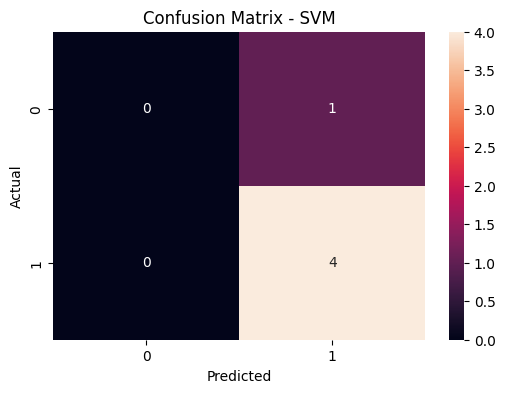

In [ ]:
# ===============================
# 7. Confusion Matrix
# ===============================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
correct = sum(y_test == y_pred)
total = len(y_test)

print(f" Akurasi SVM: {accuracy*100:.2f}%")
print(f" Benar: {correct} data")
print(f" Salah: {total - correct} data")
print(f" Total data uji: {total}")


 Akurasi SVM: 80.00%
 Benar: 4 data
 Salah: 1 data
 Total data uji: 5


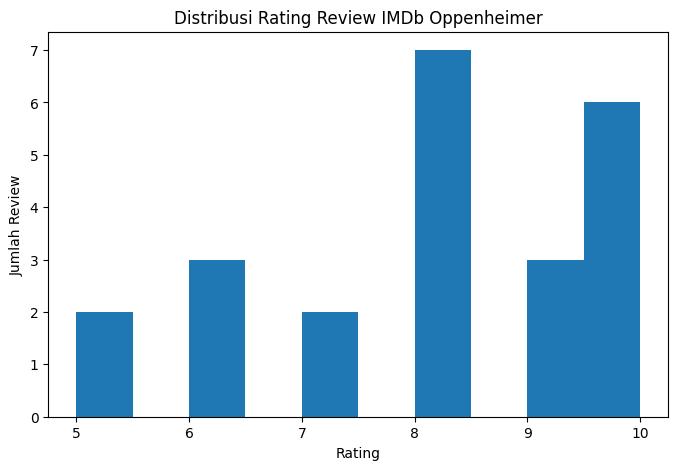

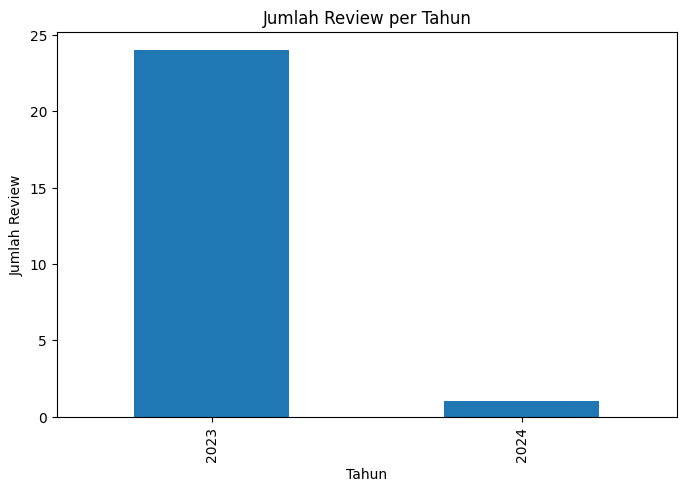

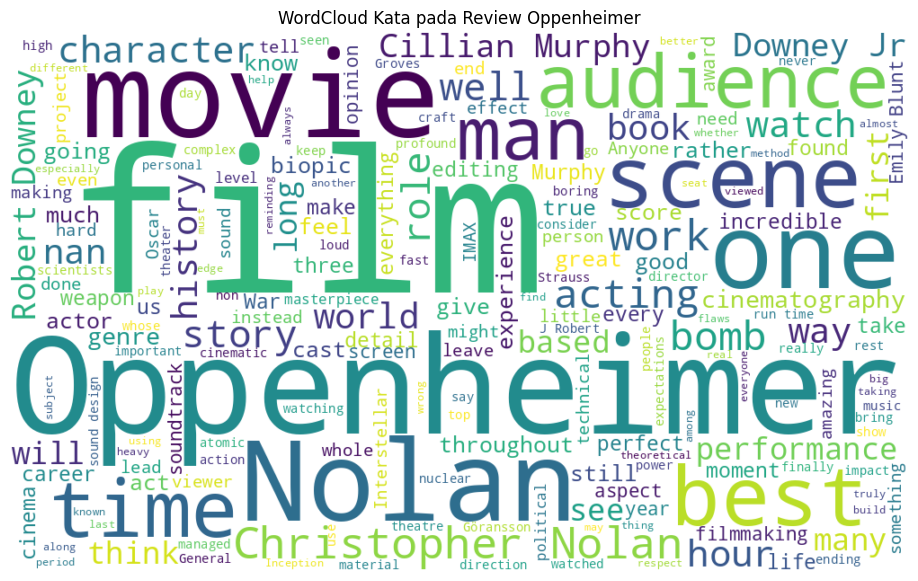

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Load dataset
df = pd.read_csv("oppenheimer_reviews_requests.csv")

# ----------------------------------
# 1️⃣ Distribusi Rating
# ----------------------------------
plt.figure(figsize=(8,5))
plt.hist(df['Rating'], bins=10)
plt.title("Distribusi Rating Review IMDb Oppenheimer")
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.show()

# ----------------------------------
# 2️⃣ Visualisasi Tren Review per Tahun
# ----------------------------------
df['Review_Date'] = pd.to_datetime(df['Review_Date'], errors='coerce')
df['Year'] = df['Review_Date'].dt.year

plt.figure(figsize=(8,5))
df['Year'].value_counts().sort_index().plot(kind='bar')
plt.title("Jumlah Review per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Review")
plt.show()

# ----------------------------------
# 3️⃣ WordCloud Review Text
# ----------------------------------
text_data = " ".join(df['Review_Text'].astype(str))

wordcloud = WordCloud(width=1000, height=600,
                      background_color='white').generate(text_data)

plt.figure(figsize=(12,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud Kata pada Review Oppenheimer")
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv("oppenheimer_reviews_requests.csv")
print(df.columns)
df.head()

Index(['Reviewer_Name', 'Review_Date', 'Rating', 'Review_Title',
       'Review_Text'],
      dtype='object')


,Reviewer_Name,Review_Date,Rating,Review_Title,Review_Text
0,Orlando_Gardner,"Jul 18, 2023",9.0,Murphy is exceptional,NaN
1,Jeremy_Urquhart,"Jul 19, 2023",8.0,"A challenging watch to be sure, but a worthwhi...",NaN
2,Bonobo13579,"Jul 20, 2023",7.0,Quality but exhausting,I'm a big fan of Nolan's work so was really lo...
3,mark-217-307033,"Jul 18, 2023",10.0,And the Oscar goes to...,I'm still collecting my thoughts after experie...
4,MrDHWong,"Jul 19, 2023",10.0,A brilliantly layered examination of a man thr...,"""Oppenheimer"" is a biographical thriller film ..."


✅ Data berhasil dimuat!
     Reviewer_Name   Review_Date  Rating  \
0  Orlando_Gardner  Jul 18, 2023     9.0   
1  Jeremy_Urquhart  Jul 19, 2023     8.0   
2      Bonobo13579  Jul 20, 2023     7.0   
3  mark-217-307033  Jul 18, 2023    10.0   
4         MrDHWong  Jul 19, 2023    10.0   

                                        Review_Title  \
0                              Murphy is exceptional   
1  A challenging watch to be sure, but a worthwhi...   
2                             Quality but exhausting   
3                           And the Oscar goes to...   
4  A brilliantly layered examination of a man thr...   

                                         Review_Text  
0                                                NaN  
1                                                NaN  
2  I'm a big fan of Nolan's work so was really lo...  
3  I'm still collecting my thoughts after experie...  
4  "Oppenheimer" is a biographical thriller film ...   

📌 Kolom yang tersedia: ['Reviewer_Name', '

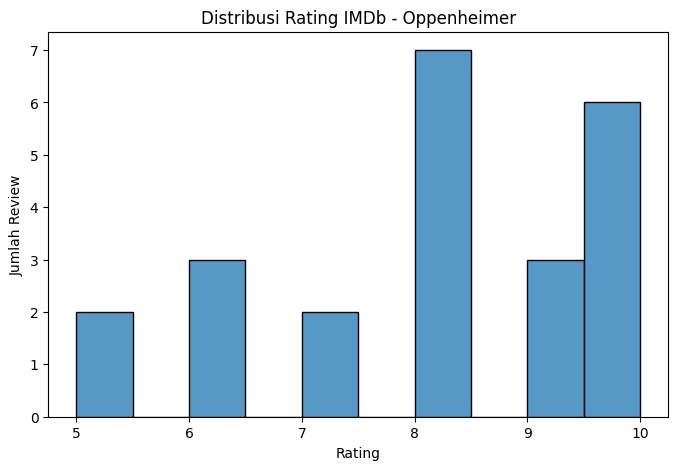

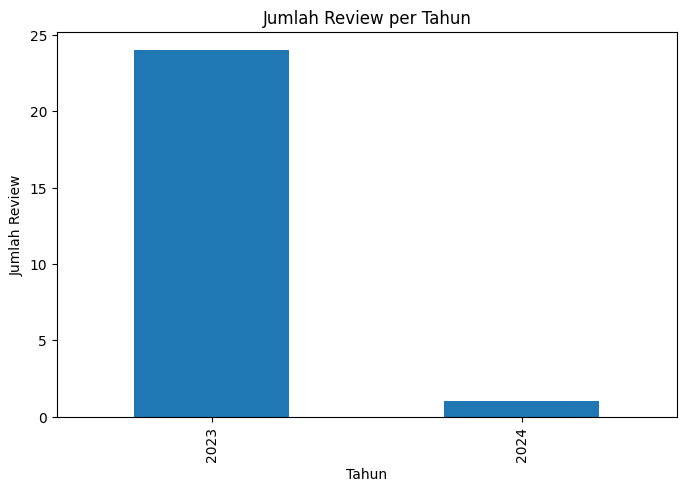

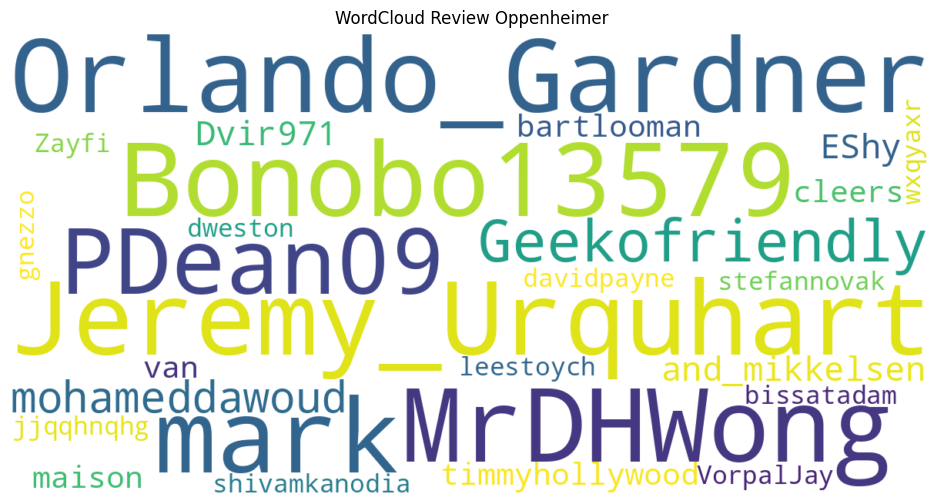

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# ================================
# Load Data
# ================================
df = pd.read_csv("oppenheimer_reviews_requests.csv")

print("✅ Data berhasil dimuat!")
print(df.head(), "\n")
print("📌 Kolom yang tersedia:", df.columns.tolist(), "\n")

# ================================
# Deteksi kolom otomatis
# ================================
reviewer_col = [c for c in df.columns if "reviewer" in c.lower()][0]
date_col = [c for c in df.columns if "date" in c.lower()][0]
rating_col = [c for c in df.columns if "rating" in c.lower()][0]
text_col = [c for c in df.columns if "review" in c.lower()][0]  # text review
title_col = [c for c in df.columns if "title" in c.lower()][0]

print("Kolom digunakan:")
print("- Reviewer:", reviewer_col)
print("- Date:", date_col)
print("- Rating:", rating_col)
print("- Title:", title_col)
print("- Review Text:", text_col, "\n")

# ================================
# Parsing Tanggal IMDb
# ================================
df[date_col] = pd.to_datetime(df[date_col], format="%b %d, %Y", errors="coerce")
df["Year"] = df[date_col].dt.year

print("✅ Parsing tanggal selesai")
print("Valid dates:", df[date_col].notna().sum())
print("Invalid dates:", df[date_col].isna().sum(), "\n")

# ================================
# Visualisasi 1: Distribusi Rating
# ================================
plt.figure(figsize=(8,5))
sns.histplot(df[rating_col], bins=10)
plt.title("Distribusi Rating IMDb - Oppenheimer")
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.grid(False)
plt.show()

# ================================
# Visualisasi 2: Review per Tahun
# ================================
if df["Year"].notna().sum() > 0:
    plt.figure(figsize=(8,5))
    df["Year"].value_counts().sort_index().plot(kind='bar')
    plt.title("Jumlah Review per Tahun")
    plt.xlabel("Tahun")
    plt.ylabel("Jumlah Review")
    plt.grid(False)
    plt.show()
else:
    print("⚠ Tidak ada data tahun yang valid untuk ditampilkan.")

# ================================
# Visualisasi 3: WordCloud
# ================================
text_data = " ".join(df[text_col].astype(str))
if len(text_data.strip()) > 0:
    wordcloud = WordCloud(width=1200, height=600, background_color="white").generate(text_data)

    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud Review Oppenheimer")
    plt.show()
else:
    print("⚠ Text review kosong, WordCloud tidak bisa dibentuk.")